In [29]:
import json
import sqlite3
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gmean

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from catboost import CatBoostClassifier, CatBoostRegressor, sum_models
from xgboost import XGBClassifier, XGBRegressor

from tqdm import tqdm

import shap
shap.initjs()

# Graphs
sns.set(context="talk", style="darkgrid")

conn = sqlite3.connect("bgg.db")

In [30]:
sql = """
select 
games.*,
zach.enjoyed
from games
left join zach on zach.bgg_id = games.BGGid
"""

df = pd.read_sql(sql, conn)
df.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,enjoyed
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,0,1,0,0,0,0,0,0,NaN
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,0,1,0,0,0,0,0,0,NaN
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,0,1,0,0,0,0,0,0,NaN
3,4,Tal der Könige,triangular box luxurious large block tal der k...,1992,2.6667,6.60006,5.67954,1.23129,2,4,...,21926,0,0,0,0,0,0,0,0,NaN
4,5,Acquire,acquire player strategically invest business t...,1964,2.5031,7.33861,7.14189,1.33583,2,6,...,21926,0,1,0,0,0,0,0,0,NaN


In [31]:
def fix_good_players(text):
    try:
        numbers = json.loads(text.replace("'", ""))
        if len(numbers) == 0:
            return 0
        return max(numbers)
    except:
        return 0

df["max_good_players"] = df.GoodPlayers.apply(fix_good_players)

In [32]:
DROP_COLS = [
    "BGGId",
    "Name",
    "Description",
    "Family",
    "ImagePath",
    "GoodPlayers",
]

X = df[~df.enjoyed.isna()].drop(DROP_COLS, axis=1)
y = X.pop("enjoyed").fillna(0)

test = df[df.enjoyed.isna()].drop(DROP_COLS, axis=1)
test_names = df[df.enjoyed.isna()][["BGGId", "Name", "BayesAvgRating", "BestPlayers"]]
test_y = test.pop("enjoyed")

X.head()

,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,BestPlayers,...,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,max_good_players
623,2000,1.8999,7.41340,7.20844,1.25358,2,2,9.035714,37.044776,2,...,21926,0,1,0,0,0,0,0,0,2
3133,1949,1.1012,3.18585,3.79929,1.72107,2,4,3.325000,16.052632,4,...,878,0,0,0,0,0,0,0,1,4
3304,-200,1.0195,2.86709,3.61566,1.64086,2,6,3.357143,16.000000,4,...,879,0,0,0,0,0,0,0,1,5
4033,1530,1.0435,2.88375,3.96529,1.76389,2,99,4.769231,26.055556,3,...,21926,0,0,0,0,0,0,1,0,3
5378,-1300,1.1697,2.69820,3.57481,1.98765,2,2,4.181818,46.034483,2,...,880,0,0,0,0,0,1,0,1,2


In [33]:
n_splits = 6
kf = KFold(n_splits=n_splits)

models = []

for train_idx, test_idx in tqdm(kf.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    cat = CatBoostClassifier(iterations=800, verbose=False, od_type="Iter", od_wait=30)
    cat.fit(X_train, y_train, eval_set=(X_test, y_test))
    models.append(cat)
    
weights = [1.0 / n_splits] * n_splits

model = sum_models(models, weights=weights)

6it [00:00, 10.27it/s]


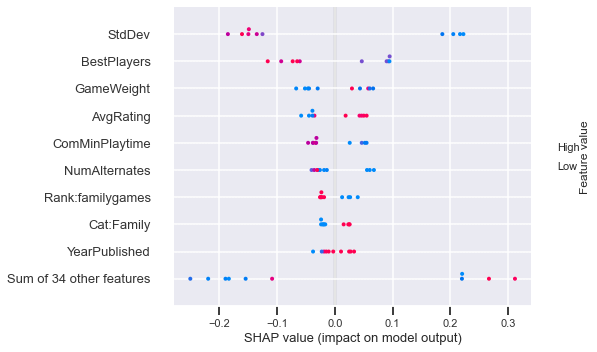

In [34]:
shap_values = shap.TreeExplainer(model)(X)
shap.plots.beeswarm(shap_values)

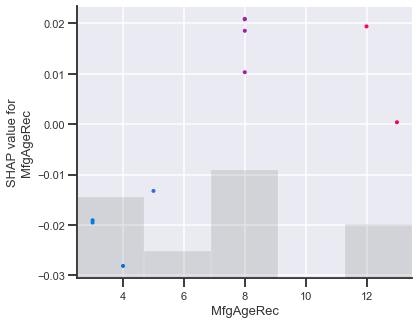

In [35]:
shap.plots.scatter(shap_values[:, "MfgAgeRec"], color=shap_values)

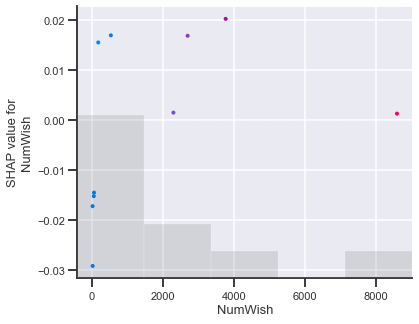

In [36]:
shap.plots.scatter(shap_values[:, "NumWish"], color=shap_values)

In [37]:
test_names["model"] = model.predict(test, "Probability")[:, 1].round(3)

(
    test_names.sort_values("model", ascending=False)
    .head(50)
    .reset_index(drop=True)
    .style
    .format("{:.1f}", subset=["BayesAvgRating"])
    .format("{:.3f}", subset=["model"])
    .background_gradient("YlGn", subset=["BayesAvgRating", "BestPlayers", "model"])
)

,BGGId,Name,BayesAvgRating,BestPlayers,model
0,183006,Qwinto,6.4,0,0.647
1,256606,Spirits of the Wild,6.5,0,0.646
2,310448,Zombie Teenz Evolution,6.2,0,0.645
3,244330,Scarabya,5.9,0,0.645
4,197443,Fugitive,6.7,2,0.644
5,213882,Mole Rats in Space,5.8,0,0.644
6,213266,Circle the Wagons,6.5,2,0.643
7,271519,Ecosystem,5.9,0,0.641
8,158339,Lost Legacy: The Starship,6.2,0,0.640
9,253684,Spring Meadow,6.2,0,0.639
